In [84]:
import tensorflow as tf
from tensorflow import keras

from keras.applications.vgg19 import VGG19
from keras.optimizers import RMSprop
from keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Data Augmentation**

- Esta função de data augmentation não tem muitas tranformações pois, como vimos num dos modelos desenvolvidos, muitas tranformações podes destorcer por completo a imagem

In [85]:
def augment(image, label):
    image = tf.image.random_rotation(image, 40) #rodar a imagem ligeiramente pus no máximo 30%
    image = tf.image.random_brightness(image, max_delta=0.1) #aplicamos um bocado de brilho
    image = tf.image.random_flip_left_right(image) #flip horizontal aleatório
    return image, label

**Batch Size**

A decisão de um *batch size* a 32 foi devido às experiências e treinos anteriores 

In [86]:

IMG_SIZE = 150
num_classes = 10
BATCH_SIZE = 32
# Carregar e preparar os dados

train_dir = '../Imagens/train/train5'
validation_dir = '../Imagens/validation'
test_dir = '../Imagens/test'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


**Carregar a classificador do outro modelo**

- Aqui estamos a reutilizar a camada classificadora do modelo T sem fine tunning

In [87]:

from tensorflow import keras
from keras import layers
from keras import layers, regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#Reaproveitamos a classificadora do modelo T, mas sem fine Tunning
model = keras.models.load_model('TL_dataAugmentation.h5')

**Carregar o modelo Pré-Treinado**

- O modelo que escolhemos foi a VGG19, por razões já justificadas anteriormente
- Embora nos testes tenhamos testado descongelar mais do que uma layer, o melhor resultado que obtivemos foi apenas quando descongelamos a primeira, o que explicamos com mais detalhe no relatório

**Descongelar Camadas**

- Após 3 treinos decidimos que a melhor opção era descongelar no máximo estas duas camadas

In [88]:
convbase = model.get_layer("vgg19")

for layer in convbase.layers:
    if layer.name in ['block5_conv3','block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False

In [89]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


**Learning Rate**

- Após os 3 treinos o melhor learing rate a que chegamos foi de 0.00001

In [90]:
from keras.utils import to_categorical
from tensorflow import keras
from keras import optimizers
from keras.optimizers import Adam

#model.load_weights('best_model.h5')
# Specify the learning rate
learning_rate = 0.00001

# Define the optimizer with the specified learning rate
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

# Compilar o modelo com o otimizador e taxa de aprendizado
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(train_dataset, epochs=15, validation_data=validation_dataset, callbacks=[reduce_lr, early_stopping, checkpoint])
model.save('Com_dataAugmentation.h5')

Epoch 1/15


1250/1250 [==============================] - 227s 179ms/step - loss: 0.2251 - accuracy: 0.9334 - val_loss: 0.2722 - val_accuracy: 0.9221 - lr: 1.0000e-05
Epoch 2/15
1250/1250 [==============================] - 234s 187ms/step - loss: 0.2123 - accuracy: 0.9395 - val_loss: 0.2681 - val_accuracy: 0.9244 - lr: 1.0000e-05
Epoch 3/15
1250/1250 [==============================] - 239s 191ms/step - loss: 0.2059 - accuracy: 0.9410 - val_loss: 0.2631 - val_accuracy: 0.9257 - lr: 1.0000e-05
Epoch 4/15
1250/1250 [==============================] - 237s 189ms/step - loss: 0.2049 - accuracy: 0.9420 - val_loss: 0.2669 - val_accuracy: 0.9255 - lr: 1.0000e-05
Epoch 5/15
1250/1250 [==============================] - 234s 187ms/step - loss: 0.1999 - accuracy: 0.9418 - val_loss: 0.2744 - val_accuracy: 0.9239 - lr: 1.0000e-05
Epoch 6/15
1250/1250 [==============================] - 233s 187ms/step - loss: 0.1923 - accuracy: 0.9455 - val_loss: 0.2748 - val_accuracy: 0.9235 - lr: 1.0000e-05
Epoch 7/15
1250/1250 

**Desempenho do modelo**

- Na nossa opinião o desempenho do modelo no geral é bom, embora com algum overfitting, podemos considerar um modelo robusto e capaz de classificar corretamente as imagens com 92% de certeza.

In [94]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:'
, val_acc)

test_loss, test_acc = model.evaluate(test_dataset)
print('test_acc:'
, test_acc)

313/313 [==============================] - 23s 71ms/step - loss: 0.2631 - accuracy: 0.9257
val_acc: 0.9257000088691711
313/313 [==============================] - 22s 71ms/step - loss: 0.2690 - accuracy: 0.9258
test_acc: 0.9258000254631042


**Análise do gráfico**


- No meu entender, ao olhar para o gráfico vejo que a accuracy do treino está a aumentar significativamente, o que indica que a rede está a conseguir modelar os dados de treino cada vez melhor ao longo do tempo
- A validação a meu ver, embora esteja a melhorar mostra algumas variações se obsevarmos não segue uma tendência ascendente suave como a linha de treino.
- Para concluir, podemos reparar que com os dados apresentados pelo gráfico a rede tem um overfitting significativo

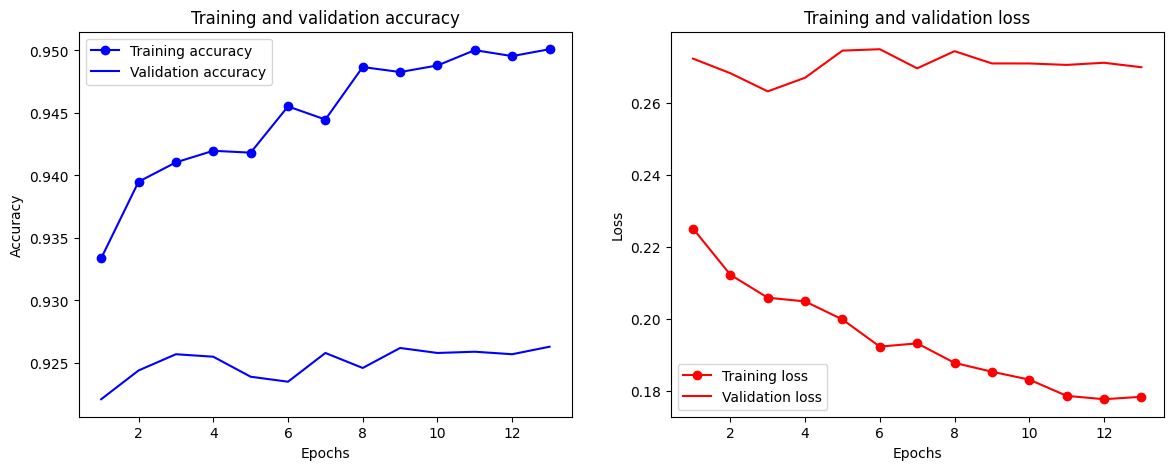

In [ ]:
import matplotlib.pyplot as plt

# Avaliar o modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
